In [1]:
import pandas as pd

### Load the under_employee dataset

In [2]:
# read CSV file from the 'data' subdirectory using a relative path
df = pd.read_csv('../data/under_employee_1997.csv')

# display the first 5 rows
df.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,1997,1,2,1,480355.5025
1,1997,1,2,2,189697.1064
2,1997,1,3,2,4137.0015
3,1997,1,3,1,15472.2717
4,1997,1,1,1,1639.3907


In [3]:
# display the last 5 rows
df.tail()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
94,1997,25,2,2,75328.8195
95,1997,25,3,1,17857.7602
96,1997,25,3,2,2210.6372
97,1997,25,1,1,220.9982
98,1997,25,1,2,325.4070


In [4]:
# check the shape of the DataFrame (rows, columns)
df.shape

(99, 5)

### Data Preprocessing

#### 1. Replcaing empty cells with NaN(Not a number)

In [5]:
import numpy as np
df.replace(' ', np.nan, inplace=True)
df.replace('  ', np.nan, inplace=True)
df.replace('   ', np.nan, inplace=True)
df.replace('    ', np.nan, inplace=True)
df.replace('     ', np.nan, inplace=True)
df.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,1997,1,2,1,480355.5025
1,1997,1,2,2,189697.1064
2,1997,1,3,2,4137.0015
3,1997,1,3,1,15472.2717
4,1997,1,1,1,1639.3907


#### 2. Drop columns with NaN values 

In [6]:
df = df.dropna(axis=1, how='all')

#### NOTE: Best way to handle missing data

**Eliminating and Imputing** are two different strategies for handling samples or features with missing values.

Eliminating simply we remove the corresponding features (columns) or samples (rows) from the dataset entirely that have a certain number of missing values. The disadvantages for this strategy, we will run the risk of losing valuable information that our classifier needs to discriminate between classes.

Imputing we handle missing data by applying different interpolation techniques to estimate the missing values. One of the most common interpolation techniques is mean imputation, where we simply replace the missing value by the mean value of the entire feature column. A convenient way to achieve this is by using the Imputer class from scikit-learn, but filling missing values with this way is also a prediction which ignore the relation between missing values and other features.

Visualizing the important characteristics of a dataset is an important and recommended first step to clarifying the correlation between features to guide us to use a regression or another simple model to predict the values of missing variables. We have tried imputation here because we cannot loose data records.

#### 2. Imputation of missing values

##### i. Univariate vs. Multivariate Imputation

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. impute.SimpleImputer). By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer). As we can see we have to try multivariate imputation because it is the most sophisticated approach is to use. (***IterativeImputer class***)

In [7]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index

In [8]:
idf.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,1997.0,1.0,2.0,1.0,480355.5025
1,1997.0,1.0,2.0,2.0,189697.1064
2,1997.0,1.0,3.0,2.0,4137.0015
3,1997.0,1.0,3.0,1.0,15472.2717
4,1997.0,1.0,1.0,1.0,1639.3907


In [9]:
X = idf.drop(['COUNT'], axis=1)
y = idf['COUNT']

# Feature selection

#### Plotting original data with regression line

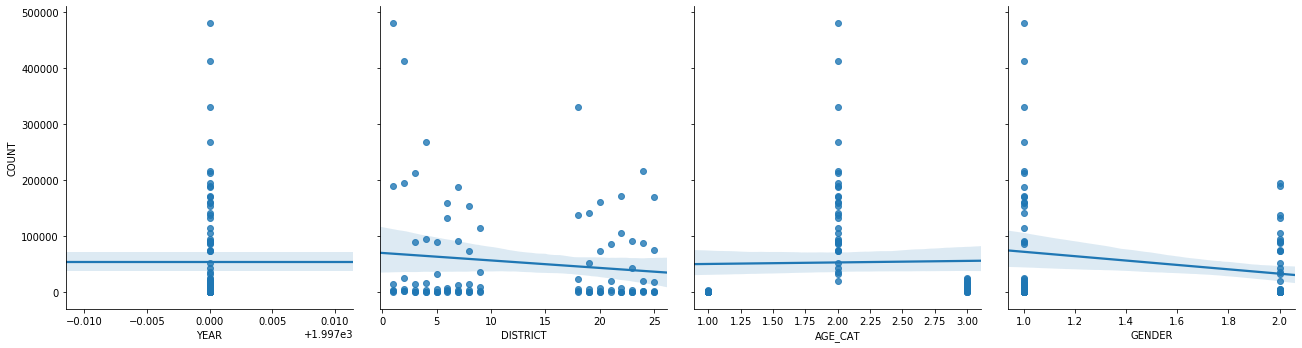

In [10]:
import seaborn as sns
%matplotlib inline

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(idf, x_vars=X.columns, y_vars='COUNT', height=5, aspect=0.9, kind='reg')

Feature selection can be done in multiple ways but there are broadly 3 categories of it.
1. Filter Method
2. Wrapper Method
3. Embedded Method

(NOTE: 2 and 3 method are suited when lesser features (~20). Since there are more than 20 features we will use filter method.)

### 1. Filter Method
Plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable. We will only select features which has correlation of above 0.5.

#### Pearson correlation heatmap

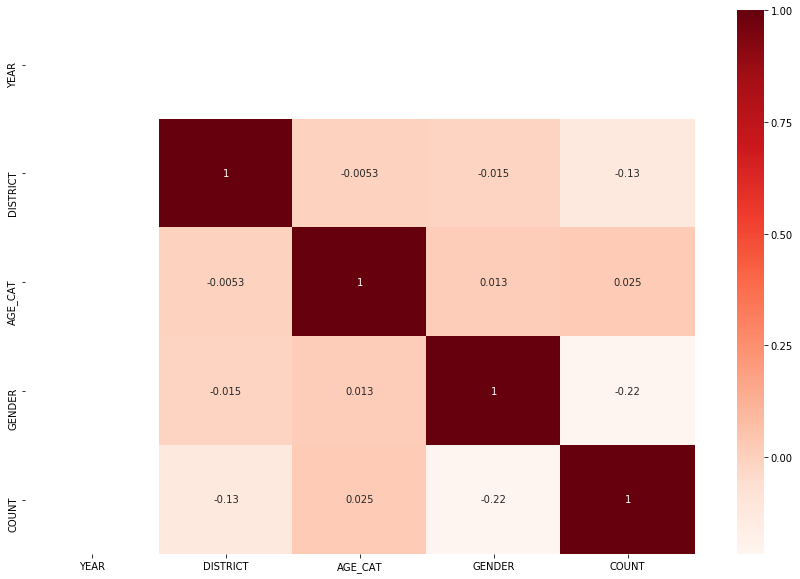

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
#Using Pearson Correlation
plt.figure(figsize=(15,10))
cor = idf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Getting the selected features using correltion matrix

In [12]:
#Correlation with output variable
cor_target = abs(cor["COUNT"])#Selecting highly correlated features
selected_features_FM = cor_target[cor_target>=0.5]
selected_features_FM = list(selected_features_FM.keys())
selected_features_FM

['COUNT']

### 2. Wrapper Method
Feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE.

#### i. Backward Elimination
Check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [13]:
import statsmodels.api as sm
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[0:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['YEAR', 'GENDER']


/home/asitha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### NOTE: Since there are not more than 20 feature we have used filter method. But filter method does not works with this dataset as we expected. So we have used backward eleimintaion. 

What are the features?
- **YEAR:**
- **GENDER:**
- **DISTRICT:** etc.

What is the response?
- **COUNT**

What else do we know?
- Because the response variable is continuous, this is a **regression** problem.

### Test the model with the subset of selected features and features that we need to check

In [14]:
# use the list to select a subset of the original DataFrame
research_features = ['YEAR', 'DISTRICT', 'AGE_CAT', 'GENDER']
X = idf[research_features]

# print the first 5 rows
X.head()

,YEAR,DISTRICT,AGE_CAT,GENDER
0,1997.0,1.0,2.0,1.0
1,1997.0,1.0,2.0,2.0
2,1997.0,1.0,3.0,2.0
3,1997.0,1.0,3.0,1.0
4,1997.0,1.0,1.0,1.0


In [15]:
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(99, 4)


In [16]:
# select a Series from the DataFrame
y = idf['COUNT']

# print the first 5 values
y.head()

0    480355.5025
1    189697.1064
2      4137.0015
3     15472.2717
4      1639.3907
Name: COUNT, dtype: float64

In [17]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(99,)


## Splitting X and y into training and testing sets

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.2)

In [19]:
# default split is 80% for training and 20% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(79, 4)
(79,)
(20, 4)
(20,)


## Scaling Data

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Finding the best linear regression algorithm

In [21]:
#import sklearn regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, SGDRegressor, PassiveAggressiveRegressor, RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

#Dictionary of all models. All models intialized with no args. Can modify any of them to test various args.
# Error: 'ARDRegression': ARDRegression(), GaussianProcessRegressor, TheilSenRegressor, SGDRegressor, KernelRidge, RANSACRegressor
models = {'LinearRegression': LinearRegression(),
          'Ridge': Ridge(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(),
          'Lars': Lars(),
          'OrthogonalMatchingPursuit': OrthogonalMatchingPursuit(),
          'BayesianRidge': BayesianRidge(),
          'PassiveAggressiveRegressor': PassiveAggressiveRegressor(),
          'HuberRegressor': HuberRegressor(),
          'DecisionTreeRegressor': DecisionTreeRegressor(),
          'MLPRegressor': MLPRegressor(),
          'KNeighborsRegressor': KNeighborsRegressor(),
          'RadiusNeighborsRegressor': RadiusNeighborsRegressor(),
          'SVR': SVR(gamma='scale'),
          'NuSVR': NuSVR(gamma='scale'),
          'LinearSVR': LinearSVR(),
          'RandomForestRegressor': RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
         }

### NOTE: Non-linear Regressors
#### Decision Trees
Decision Trees, also referred to as Classification and Regression Trees (CART), work for both categorical and continuous input and output variables. It works by splitting the data into two or more homogeneous sets based on the most significant splitter among the independent variables. The best differentiator is the one that minimizes the cost metric. The cost metrics for a classification tree is often the entropy or the gini index, whereas, for a regression tree, the default metric is the mean squared error.
#### Random Forest
Decision Trees are useful, but the problem is that they often tend to overfit the training data leading to high variances in the test data. Random Forest algorithms overcome this shortcoming by reducing the variance of the decision trees. They are called 'Forest' because they are the collection, or ensemble, of several decision trees. One major difference between a Decision Tree and a Random Forest model is on how the splits happen. In Random Forest, instead of trying splits on all the features, a sample of features is selected for each split, thereby reducing the variance of the model

## Model evaluation metrics for regression

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. Instead, we need evaluation metrics designed for comparing continuous values.

Let's create some example numeric predictions, and calculate **three common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

In [22]:
#Import non-sklearn packages
import numpy as np
import time
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

print_coef = False

for key, model in models.items():
    begin = time.time()
    model.fit(X_train,y_train)
    print(key + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test,preds)
    r2 = r2_score(y_test,preds)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(key + ' MSE: ' + str(mse))
    print(key + ' R2 ' + str(r2))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if print_coef:
        print('Coefficients:')
        print(model.coef_)
    print('')

LinearRegression Train time: 4.823605219523112e-05 minutes
LinearRegression MSE: 4886689302.772873
LinearRegression R2 0.012822235211123578
Accuracy: -0.11 (+/- 0.26)

Ridge Train time: 2.855857213338216e-05 minutes
Ridge MSE: 4880427333.110351
Ridge R2 0.01408723833115344
Accuracy: -0.11 (+/- 0.26)

Lasso Train time: 1.494884490966797e-05 minutes
Lasso MSE: 4886633263.847997
Lasso R2 0.012833555836842425
Accuracy: -0.11 (+/- 0.26)

ElasticNet Train time: 2.4469693501790366e-05 minutes
ElasticNet MSE: 4791965605.878309
ElasticNet R2 0.03195771151813043
Accuracy: -0.07 (+/- 0.17)

Lars Train time: 1.718600591023763e-05 minutes
Lars MSE: 4886689302.772875
Lars R2 0.012822235211123245
Accuracy: -0.11 (+/- 0.26)

OrthogonalMatchingPursuit Train time: 1.4762083689371744e-05 minutes
OrthogonalMatchingPursuit MSE: 4726166802.537172
OrthogonalMatchingPursuit R2 0.04524996555425864
Accuracy: -0.15 (+/- 0.24)

BayesianRidge Train time: 1.808802286783854e-05 minutes
BayesianRidge MSE: 5024021637.

/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarn

MLPRegressor Train time: 0.00265351931254069 minutes


/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor MSE: 7091312308.265404
MLPRegressor R2 -0.43254162484220826
Accuracy: -0.44 (+/- 0.38)

KNeighborsRegressor Train time: 6.107489267985026e-06 minutes
KNeighborsRegressor MSE: 1312826238.162751
KNeighborsRegressor R2 0.7347912275473901
Accuracy: 0.64 (+/- 0.16)

RadiusNeighborsRegressor Train time: 7.279713948567709e-06 minutes
RadiusNeighborsRegressor MSE: 837687238.7907466
RadiusNeighborsRegressor R2 0.8307757737918027
Accuracy: 0.58 (+/- 0.20)

SVR Train time: 1.7233689626057942e-05 minutes
SVR MSE: 6669362018.217448
SVR R2 -0.3473019219731923
Accuracy: -0.36 (+/- 0.33)

NuSVR Train time: 2.3738543192545572e-05 minutes
NuSVR MSE: 4950698158.139705
NuSVR R2 -0.00010842496648755251
Accuracy: -0.04 (+/- 0.11)

LinearSVR Train time: 2.2733211517333983e-05 minutes
LinearSVR MSE: 7084797777.969465
LinearSVR R2 -0.43122560103595875
Accuracy: -0.44 (+/- 0.38)

RandomForestRegressor Train time: 0.00439074436823527 minutes
RandomForestRegressor MSE: 1513525520.307099
RandomForestR

### Select the best model (Which has the hieghest accuary and heighest speed)

In [23]:
begin = time.time()
best_model = KNeighborsRegressor()
best_model_name = 'KNeighborsRegressor'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNeighborsRegressor Train time: 2.1473566691080728e-05 minutes
KNeighborsRegressor MSE: 1312826238.162751
KNeighborsRegressor R2 0.7347912275473901
Accuracy: 0.64 (+/- 0.16)


### NOTE:  In KNeighborsRegressor we can increase the accuracy by changing the number of n_neighous to find better model. So we tried n_neighbours from 0-20.

In [24]:
for i in range(1, 20):
    begin = time.time()
    model = KNeighborsRegressor(n_neighbors=i)
    model_name = 'KNeighborsRegressor'
    model.fit(X_train,y_train)
    print(model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes"+ " neighbours: " + str(i))
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test,preds)
    r2 = r2_score(y_test,preds)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model_name + ' MSE: ' + str(mse))
    print(model_name + ' R2 ' + str(r2))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNeighborsRegressor Train time: 2.6881694793701172e-05 minutes neighbours: 1
KNeighborsRegressor MSE: 3789303488.758004
KNeighborsRegressor R2 0.23450910905749445
Accuracy: 0.57 (+/- 0.82)
KNeighborsRegressor Train time: 1.3665358225504558e-05 minutes neighbours: 2
KNeighborsRegressor MSE: 2062388285.8287094
KNeighborsRegressor R2 0.5833694896510232
Accuracy: 0.76 (+/- 0.26)
KNeighborsRegressor Train time: 1.22984250386556e-05 minutes neighbours: 3
KNeighborsRegressor MSE: 2616022322.478769
KNeighborsRegressor R2 0.4715278772732675
Accuracy: 0.70 (+/- 0.21)
KNeighborsRegressor Train time: 5.412101745605469e-06 minutes neighbours: 4
KNeighborsRegressor MSE: 1481490056.9384403
KNeighborsRegressor R2 0.7007188400261981
Accuracy: 0.63 (+/- 0.15)
KNeighborsRegressor Train time: 6.234645843505859e-06 minutes neighbours: 5
KNeighborsRegressor MSE: 1312826238.162751
KNeighborsRegressor R2 0.7347912275473901
Accuracy: 0.64 (+/- 0.16)
KNeighborsRegressor Train time: 5.559126536051432e-06 minutes

### Best KNeighborsRegressor with 2 neighbours

In [25]:
begin = time.time()
best_model = KNeighborsRegressor(n_neighbors=2)
best_model_name = 'KNeighborsRegressor'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNeighborsRegressor Train time: 1.9880135854085288e-05 minutes
KNeighborsRegressor MSE: 2062388285.8287094
KNeighborsRegressor R2 0.5833694896510232
Accuracy: 0.76 (+/- 0.26)


In [26]:
import pickle
# save the model to disk
filename = '../models/under_employee.sav'
pickle.dump(best_model, open(filename, 'wb'))